In [1]:
import encodermap as em
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mat
#import gromacs
import glob2 as glob
import os
import sys
import pickle
import math
import subprocess
import seaborn
import pandas as pd
import random
import matplotlib.cm as cm
import pyemma.plots as mplt
import scipy as sp
sys.path.insert(1, "/home/nicolas.schneider/nicolas/master_thesis/backward-v5")
from collections import defaultdict
import pprint
sys.path.insert(1, '/home/nicolas.schneider/soft/running_rabbit')


from sim_class import *
from utility_functions import *

In [2]:
##Parameters:
template_name = "ASP10_charged_1" + ".pickle" #template to load
run_location = "MLS" #"local" run on server or local
aa_sim_count = 100   #desired number of aa sims
rr_template = "em_&_production_after_backmapping_prod" #running rabbit template to use

In [3]:
#connect to server
if run_location == "MLS":
    client = connect_MLS()
    ssh = establish_sftp(client)
elif run_location == "local":
    client = 0
    ssh = 0

banner_timeout =  None
auth_timeout =  None
Your OTP: 539231


In [4]:
#load the template
Cluster_sim.load_state(os.path.join("/home/nicolas.schneider/nicolas/master_thesis/serialized_objects/", template_name))

Output files are saved to /home/nicolas.schneider/nicolas/master_thesis/evaluation_data/CG_sim/nacl_iso_charged/ASP_10/template1 as defined in 'main_path' in the parameters.


In [5]:
#verify loaded template
vars(Cluster_sim)

mappingproxy({'__module__': 'sim_class',
              'is_class_object': True,
              'base_directory': '/home/nicolas.schneider/nicolas/master_thesis/',
              'CG_sim_directory': '/home/nicolas.schneider/nicolas/master_thesis/CG_sim/martini3/',
              'evaluation_data_base_directory': '/home/nicolas.schneider/nicolas/master_thesis/evaluation_data/',
              'evaluation_data_spec_directory': '/home/nicolas.schneider/nicolas/master_thesis/evaluation_data/CG_sim/nacl_iso_charged/ASP_10/',
              'sel_charges': ['nacl_iso_charged/'],
              'sel_peptides': ['ASP_10/'],
              'descriptor_selection': 'name BB',
              'high_d_data_concat': array([[3.9102431 , 6.54064169, 7.2145651 , ..., 3.0724576 , 4.99099369,
                      3.2295541 ],
                     [3.78549762, 6.05392334, 6.73869116, ..., 3.34365028, 6.43350707,
                      3.41906436],
                     [2.9799344 , 5.90338853, 6.85929973, ..., 3.3970

In [6]:
#create run folder
Cluster_sim.run_folder = make_run_folder(os.path.join(Cluster_sim.evaluation_data_spec_directory, "runs"))

os.mkdir(Cluster_sim.run_folder + "/evaluation_data/")

os.mkdir(Cluster_sim.run_folder + "/figures/")

os.mkdir(Cluster_sim.run_folder + "/traj_frames/")

In [7]:
#project cg data
low_d_projection_cg = Cluster_sim.e_map.encode(Cluster_sim.high_d_data_concat)

In [8]:
#backmapping selection algorithm
number_bins = 30 #will be squared --< 30*30 = 900 how many bins to use
number_picks = aa_sim_count

histo, xedges, yedges = np.histogram2d(low_d_projection_cg[:,0], 
                                       low_d_projection_cg[:,1], 
                                       bins=number_bins)

Cluster_sim.pap_lst_new_starting_structures = []

N = number_bins**2

# Convert it into a 1D array
histo_1d = histo.flatten()

# Find the indices in the 1D array
idx_1d = histo_1d.argsort()[-N:]

# convert the idx_1d back into indices arrays for each dimension
x_idx, y_idx = np.unravel_index(idx_1d[::-1], histo.shape)
i = 0
while len(Cluster_sim.pap_lst_new_starting_structures)<number_picks:
    x_bin_number = x_idx[i]
    y_bin_number = y_idx[i]
    
    population = histo[x_bin_number, y_bin_number]
    i += 1
    
    x_range = [xedges[x_bin_number], xedges[x_bin_number+1]]
    y_range = [yedges[y_bin_number], yedges[y_bin_number+1]]
    
    lst_candidates = []
    for idx, data_point_projection in enumerate(low_d_projection_cg):
        if data_point_projection[0]>x_range[0]:
            if data_point_projection[0]<x_range[1]:
                if data_point_projection[1]>y_range[0]:
                    if data_point_projection[1]<y_range[1]:
                        lst_candidates.append(idx)
    picks_per_bin = max((1,min((round(population/histo.sum()*number_picks),number_picks-len(Cluster_sim.pap_lst_new_starting_structures)))))
    chosen_candidates = np.random.choice(lst_candidates,
                                         size = picks_per_bin,
                                         replace = False)
                                        
    for chosen_candidate in chosen_candidates:
        Cluster_sim.pap_lst_new_starting_structures.append(chosen_candidate)

    progress(len(Cluster_sim.pap_lst_new_starting_structures), number_picks)

In [9]:
#random selection for comparison
rand_lst_new_starting_structures = np.random.choice(len(low_d_projection_cg), size = 100, replace = False)

<IPython.core.display.Javascript object>


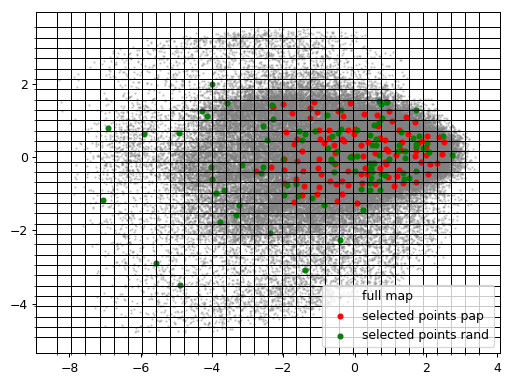

In [10]:
#plot the selection
%matplotlib notebook
fig, ax = plt.subplots()
ax.scatter(low_d_projection_cg[:, 0], 
           low_d_projection_cg[:, 1], 
           c="grey",
           alpha=0.3,
           s=1, 
           label="full map")

ax.scatter(low_d_projection_cg[Cluster_sim.pap_lst_new_starting_structures, 0], 
           low_d_projection_cg[Cluster_sim.pap_lst_new_starting_structures, 1], 
           c="red",
           alpha=1,
           s=15, 
           label="selected points pap")

ax.scatter(low_d_projection_cg[rand_lst_new_starting_structures, 0], 
           low_d_projection_cg[rand_lst_new_starting_structures, 1], 
           c="green",
           alpha=1,
           s=15, 
           label="selected points rand")

ax.set_xticks(xedges, minor=True)
ax.set_yticks(yedges, minor=True)
ax.xaxis.grid(True, which='minor', color ="black")
ax.yaxis.grid(True, which='minor', color ="black")

plt.legend()
#plt.axis("off")
plt.tight_layout()
plt.savefig(Cluster_sim.run_folder + "/figures" + "/2d_indexed_plot.png")

In [11]:
#write pdb of selected frames
Cluster_sim.selected_sim_dict = defaultdict(list)
for new_starting_structure in Cluster_sim.pap_lst_new_starting_structures:
    Cluster_sim.selected_sim_dict[Cluster_sim.frame_dict_concat_cg[new_starting_structure][-1]].append(Cluster_sim.frame_dict_concat_cg[new_starting_structure][0:-1])
for sim in Cluster_sim.selected_sim_dict:
    sim.write_frames(Cluster_sim.selected_sim_dict[sim], Cluster_sim.run_folder)

/home/nicolas.schneider/miniconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:1080: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/nicolas.schneider/miniconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:1080: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/nicolas.schneider/miniconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:1080: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  "".format(attrname, default))
/home/nicolas.schneider/miniconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:1080: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/nicolas.schneider/miniconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:1080: UserWarning: Found no information for attr: 'tem

In [12]:
#backmap selected frames
Cluster_sim.backward_frames(Cluster_sim, Cluster_sim.run_folder, rr_template, sims = Cluster_sim.selected_sim_dict)

cluster_3
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-11531-nacl_iso_charged-ASP_10-cluster_3-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charmm36.map).
Error reading charmm36 to martini mapping for TYR (file: /home/nicolas.schne

Peptide set to charged: nacl_iso_charged




 name_pre: eq5
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-4178-nacl_iso_charged-ASP_10-cluster_3-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charmm36.map).
Error reading charmm36 to m

Peptide set to charged: nacl_iso_charged




 name_pre: eq5
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-7704-nacl_iso_charged-ASP_10-cluster_3-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charmm36.map).
Error reading charmm36 to m

Peptide set to charged: nacl_iso_charged




 name_pre: eq5
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-13925-nacl_iso_charged-ASP_10-cluster_3-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charmm36.map).
Error reading charmm36 to 

Peptide set to charged: nacl_iso_charged




 name_pre: eq5
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-5887-nacl_iso_charged-ASP_10-cluster_5-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charmm36.map).
Error reading charmm36 to m

Peptide set to charged: nacl_iso_charged




 name_pre: eq5
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-7632-nacl_iso_charged-ASP_10-cluster_5-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charmm36.map).
Error reading charmm36 to m

Peptide set to charged: nacl_iso_charged




 name_pre: eq5
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-983-nacl_iso_charged-ASP_10-cluster_5-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charmm36.map).
Error reading charmm36 to ma

Peptide set to charged: nacl_iso_charged




 name_pre: eq5
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-15679-nacl_iso_charged-ASP_10-cluster_5-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charmm36.map).
Error reading charmm36 to 

Peptide set to charged: nacl_iso_charged




 name_pre: eq5
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-3852-nacl_iso_charged-ASP_10-cluster_19-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charmm36.map).
Error reading charmm36 to 

Peptide set to charged: nacl_iso_charged




 name_pre: eq5
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-14404-nacl_iso_charged-ASP_10-cluster_19-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charmm36.map).
Error reading charmm36 to

Peptide set to charged: nacl_iso_charged




 name_pre: eq5
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-14113-nacl_iso_charged-ASP_10-cluster_19-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charmm36.map).
Error reading charmm36 to

Peptide set to charged: nacl_iso_charged




 name_pre: eq5









end of loop






cluster_4
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-3939-nacl_iso_charged-ASP_10-cluster_4-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charm

Peptide set to charged: nacl_iso_charged




 name_pre: eq5
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-12775-nacl_iso_charged-ASP_10-cluster_4-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charmm36.map).
Error reading charmm36 to 

Peptide set to charged: nacl_iso_charged




 name_pre: eq5
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-2673-nacl_iso_charged-ASP_10-cluster_4-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charmm36.map).
Error reading charmm36 to m

Peptide set to charged: nacl_iso_charged




 name_pre: eq5
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-6319-nacl_iso_charged-ASP_10-cluster_4-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charmm36.map).
Error reading charmm36 to m

Peptide set to charged: nacl_iso_charged




 name_pre: eq5
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-7491-nacl_iso_charged-ASP_10-cluster_4-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charmm36.map).
Error reading charmm36 to m

Peptide set to charged: nacl_iso_charged




 name_pre: eq5
active_aa_sim_dir:  /home/nicolas.schneider/nicolas/master_thesis/AA_sim/backward_atomistic/nacl_iso_charged/ASP_10/runs/run69/aa_structures/selected_traj_-19518-nacl_iso_charged-ASP_10-cluster_4-CG_sim-
Error reading charmm27 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm36 to martini mapping for ALA (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/arg.charmm36.map).
Error reading charmm27 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm36 to martini mapping for TRP (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/tyr.charmm36.map).
Error reading charmm27 to martini mapping for TYR (file: /home/nicolas.schneider/nicolas/master_thesis/backward-v5/Mapping/val.charmm36.map).
Error reading charmm36 to 

In [13]:
#create aa sim list
Cluster_sim.aa_sim_list = []
for cg_sim in Cluster_sim.selected_sim_dict:
    for aa_sim in cg_sim.child_sims:
        Cluster_sim.aa_sim_list.append(aa_sim)
        
print(Cluster_sim.aa_sim_list)
print(len(Cluster_sim.aa_sim_list))

[<sim_class.Cluster_sim object at 0x7f2c44e10dd0>, <sim_class.Cluster_sim object at 0x7f28ee08ebd0>, <sim_class.Cluster_sim object at 0x7f28ee08e450>, <sim_class.Cluster_sim object at 0x7f27686e69d0>, <sim_class.Cluster_sim object at 0x7f2768658110>, <sim_class.Cluster_sim object at 0x7f27685d7a50>, <sim_class.Cluster_sim object at 0x7f2768673bd0>, <sim_class.Cluster_sim object at 0x7f276864ec10>, <sim_class.Cluster_sim object at 0x7f27c028e0d0>, <sim_class.Cluster_sim object at 0x7f27686655d0>, <sim_class.Cluster_sim object at 0x7f2768618310>, <sim_class.Cluster_sim object at 0x7f27c05142d0>, <sim_class.Cluster_sim object at 0x7f27686dbe10>, <sim_class.Cluster_sim object at 0x7f27686cead0>, <sim_class.Cluster_sim object at 0x7f27686cea50>, <sim_class.Cluster_sim object at 0x7f28edff4210>, <sim_class.Cluster_sim object at 0x7f27686a5250>, <sim_class.Cluster_sim object at 0x7f27686ae110>, <sim_class.Cluster_sim object at 0x7f27686a49d0>, <sim_class.Cluster_sim object at 0x7f27686a4190>,

In [14]:
#run the sims
Cluster_sim.run_sim(Cluster_sim.aa_sim_list, location =  run_location, client=client, ssh=ssh)

uploaded:  init0.gro
uploaded:  init0.top
uploaded:  setup0.sh
uploaded:  em0.mdp
uploaded:  make_ndx.top
uploaded:  make_ndx.gro
uploaded:  setup.log
uploaded:  index.ndx
uploaded:  em0.top
uploaded:  em0_out.mdp
uploaded:  em0.tpr
uploaded:  em0.log
uploaded:  em0.trr
uploaded:  em0.edr
uploaded:  em0.gro
uploaded:  init.top
uploaded:  #posre.itp.1#
uploaded:  init.gro
uploaded:  setup.sh
uploaded:  em1.mdp
uploaded:  em2.mdp
uploaded:  em3.mdp
uploaded:  eq1.mdp
uploaded:  eq2.mdp
uploaded:  eq3.mdp
uploaded:  eq4.mdp
uploaded:  eq5.mdp
uploaded:  em_sol.mdp
uploaded:  eq_nvt_ps.mdp
uploaded:  eq_npt_ps.mdp
uploaded:  production.mdp
uploaded:  #posre.itp.2#
uploaded:  posre.itp


IndexError: list index out of range

for sim in Cluster_sim.aa_sim_list:
    print(command_return(client, "sacct --format State -j " + str(sim.jobname))[2])

cwd = '/home/nicolas.schneider/nicolas/master_thesis'
!cd $cwd

In [ ]:
#calculate e2e distance of cg sims
e2e_dist_ts_concat = []

for sim in Cluster_sim.cg_sim_list:
    e2e_dist_ts_concat += sim.gen_end2end_dist_ts()

Cluster_sim.coarsegrain(Cluster_sim.aa_sim_list)

In [ ]:
#generate aa sim high d data
for aa_sim in Cluster_sim.aa_sim_list:
    aa_sim.gen_pair_dist_ts("name CA", sample_frames = len(aa_sim.universe.trajectory))#(Cluster_sim.descriptor_selection, sample_frames = len(aa_sim.universe.trajectory))
    
high_d_data_concat_aa, frame_dict_concat_aa = Cluster_sim.concatenate_high_d_data(Cluster_sim.aa_sim_list)
high_d_data_concat_norm_aa, high_d_data_concat_norm_cg = Cluster_sim.norm_high_d_data(high_d_data_concat_aa, high_d_data_concat_cg)

In [ ]:
#encodermap projection of high d data
low_d_projection_aa = Cluster_sim.e_map.encode(high_d_data_concat_aa)
low_d_projection_cg = Cluster_sim.e_map.encode(high_d_data_concat_cg)

In [ ]:
#plot the free energy of the aa sims
projection_total = low_d_projection_cg
fig = plt.figure(figsize=(4.5, 4.5), dpi=200, facecolor='white')
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor("white")
ax.axis('off')

mplt.plot_free_energy(np.vstack(projection_total)[:,0], np.vstack(projection_total)[:,1], ax=ax,
                      cmap='nipy_spectral', ncontours=100, nbins=200)
#plt.savefig('savepath.png', bbox_inches="tight")
plt.show()

In [ ]:
#save the results(Cluster_sim class and all its objects)
obj_name = "sim_obj_evaluated" + ".pickle"
Cluster_sim.save_state(os.path.join(Cluster_sim.run_folder,obj_name))